# **Загрузка Датасета**

Попробовал загрузить Датасет таким способом.
Если что мои данные json:

lebedevmaksims

f8bd2782c1da3b1fac735dd86b985622

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lebedevmaksims
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:40<00:00, 18.2MB/s]


# **Необходимые для работы библиотеки**

In [2]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from glob import glob
from keras.preprocessing.image import img_to_array

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


# **Считаем наш Датасет и проверим из чего он состоит**

Посмотрим какие файлы есть в папках и загрузим картинку из Датасета (и выучим для себя пару новых функций)

In [3]:
for i in os.walk('/content'):
    print(i)

('/content', ['.config', 'animal-faces', 'sample_data'], [])
('/content/.config', ['configurations', 'logs'], ['active_config', 'config_sentinel', 'default_configs.db', 'gce', '.last_update_check.json', '.last_opt_in_prompt.yaml', '.last_survey_prompt.yaml'])
('/content/.config/configurations', [], ['config_default'])
('/content/.config/logs', ['2024.06.12'], [])
('/content/.config/logs/2024.06.12', [], ['18.21.56.470820.log', '18.21.55.790625.log', '18.21.24.034464.log', '18.21.44.115760.log', '18.21.35.197821.log', '18.20.59.291508.log'])
('/content/animal-faces', ['afhq'], [])
('/content/animal-faces/afhq', ['val', 'train'], [])
('/content/animal-faces/afhq/val', ['cat', 'dog', 'wild'], [])
('/content/animal-faces/afhq/val/cat', [], ['pixabay_cat_002212.jpg', 'pixabay_cat_003048.jpg', 'pixabay_cat_004480.jpg', 'flickr_cat_000096.jpg', 'pixabay_cat_004586.jpg', 'pixabay_cat_003811.jpg', 'pixabay_cat_004337.jpg', 'pixabay_cat_003046.jpg', 'pixabay_cat_002081.jpg', 'pixabay_cat_002807.

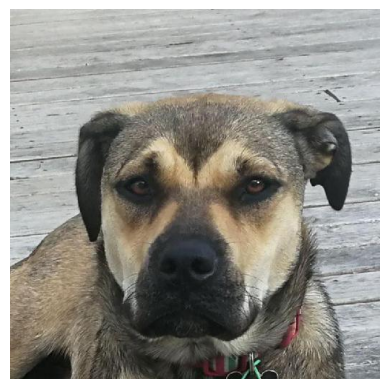

In [4]:
img = np.asarray(Image.open('/content/animal-faces/afhq/train/dog/flickr_dog_000008.jpg'))
img_array = img_to_array(img)
img_array = img_array / 255.0

plt.imshow(img_array)
plt.axis('off')
plt.show()

Датасет состоит из двух папок: TRAIN и VAL, каждая из которых в свою очередь состоит из папок cat, dog, wild.
Соберем папки и выведем информацию о Датасете. В итоге видим в нашем Датасете:
- столбец image_paths: указан путь к картинке
- столбец labels: метка к которой относится картинка
- как и положено у нас всего три уникальных метки: ['dog' 'cat' 'wild']
- количество строк 16130 (что соответствует описанию на kaggle), столбцов 2.

In [5]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq/"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      labels.append(label)
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels'])
print(data_df["labels"].unique())
data_df.head()

['cat' 'dog' 'wild']


,image_paths,labels
0,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
1,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
2,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
3,/content/animal-faces/afhq/val/cat/flickr_cat_...,cat
4,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat


In [6]:
data_df.shape

(16130, 2)

# **Разделим Датасет на Train, Validation и Test**

Разделим Датасет на три части Train/Validation/Test путем разбиения Датасета сперва на Train/Test в пропорции 70/30, а затем разобьем Test на Validation/Test в пропории 50/50.

In [7]:
train=data_df.sample(frac=0.7,random_state=7)
test=data_df.drop(train.index)

val=test.sample(frac=0.5,random_state=7)
test=test.drop(val.index)

train.shape, val.shape, test.shape

((11291, 2), (2420, 2), (2419, 2))

# **Предобработка объектов Датасета**

Преобразуем метки labels с помощью labelEncoder в числовой формат.
Преобразуем все картинки в один формат и конвертируем в тензоры.

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
    ])

# **Сформируем класс Датасета**

С помощью преобразований выше сформируем класс Датасета на основании класса PyTorch, изменим некоторые функции этого класса чтобы обучение было более эффективным.

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

# **Аугментация**

In [10]:
trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

In [11]:
transform = transforms.Compose([transforms.ToTensor()])

paths = []
labels = []
label_map = {0:"Cat",
             1:"Dog",
             2:"Wild"
            }

for cat_path in glob("../input/animal-faces/afhq/train/cat/*") + glob("../input/animal-faces/afhq/val/cat/*"):
    paths.append(cat_path)
    labels.append(0)

for dog_path in glob("../input/animal-faces/afhq/train/dog/*") + glob("../input/animal-faces/afhq/val/dog/*"):
    paths.append(dog_path)
    labels.append(1)

for wild_path in glob("../input/animal-faces/afhq/train/wild/*") + glob("../input/animal-faces/afhq/val/wild/*"):
    paths.append(wild_path)
    labels.append(2)

# **Создание объектов Датасета**

Создадим три объекта из нашего Датасета: Train/Val/Test с помощью transform который был определен выше

In [10]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

# **Выведем на экран несколько картинок из нашего Датасета**

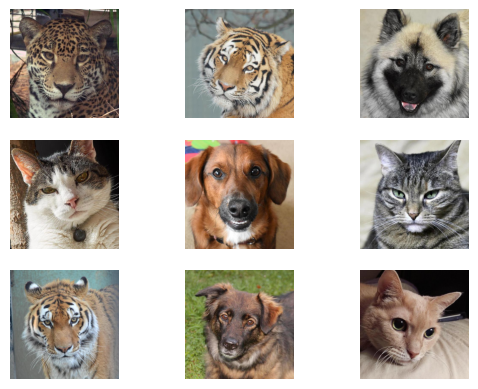

In [11]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

# **Гиперпараметры**

Выведем в отдельный размер гиперпараметры:
- скорость обучения
- размер батча
- количество эпох

In [12]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 5

# **Загрузчик данных**

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# **Нейросеть**

В модели будет три слоя свертки:
- первый слой на вход полчуает 3 признака, на выход 32
- второй слой на вход получает 32 прзнака, на выход 64
- третий слой на вход получает 64 признака, на выход 128
- pooling layer 2x2
- функция активации ReLu

После этого у нас будет flatten слой для векторизации карт объектов, за которым следует линейный слой формs (128, 16, 16), что означает 128 карт объектов, размером 16x16, поскольку изображение начинается с 128x128 и делится на 2 три раза после каждого объединения слоев.
В конце у нас будет выходной линейный слой с длиной уникальных значений меток.

In [14]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
      self.pooling = nn.MaxPool2d(2,2)
      self.relu = nn.ReLU()
      self.flatten = nn.Flatten()
      self.linear = nn.Linear((128 * 16 * 16), 128)
      self.output = nn.Linear(128, len(data_df['labels'].unique()))


    def forward(self, x):
      x = self.conv1(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device)

# **Параметры модели**

Выведем параметры модели

In [15]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

# **Функция потерь и Оптимизатор**

В качестве функции потерь возьмем CrossEntropy

В качестве оптимизатора используем Adam

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

# **Обучение модели**

In [17]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)


Epoch 1/5, Train Loss: 3.2739 Train Accuracy 80.542
              Validation Loss: 0.3888 Validation Accuracy: 90.9917
Epoch 2/5, Train Loss: 1.5039 Train Accuracy 92.4187
              Validation Loss: 0.2658 Validation Accuracy: 93.6777
Epoch 3/5, Train Loss: 1.0481 Train Accuracy 94.4646
              Validation Loss: 0.2352 Validation Accuracy: 94.2149
Epoch 4/5, Train Loss: 0.6986 Train Accuracy 96.5282
              Validation Loss: 0.1844 Validation Accuracy: 95.7025
Epoch 5/5, Train Loss: 0.5422 Train Accuracy 97.3519
              Validation Loss: 0.2684 Validation Accuracy: 93.7603


# **Тест модели**

Протестируем нейросеть на тестовой выборке.
Модель показывает следующие результаты:
- Accuracy: 93,8%
- Loss: 0.02

In [18]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 93.8818 and Loss is 0.0257


# **Отрисуем процесс обучения**

Построим графики процесса оучения:
- Training and Validation Loss по Эпохам
- Training and Validation Accuracy по Эпохам

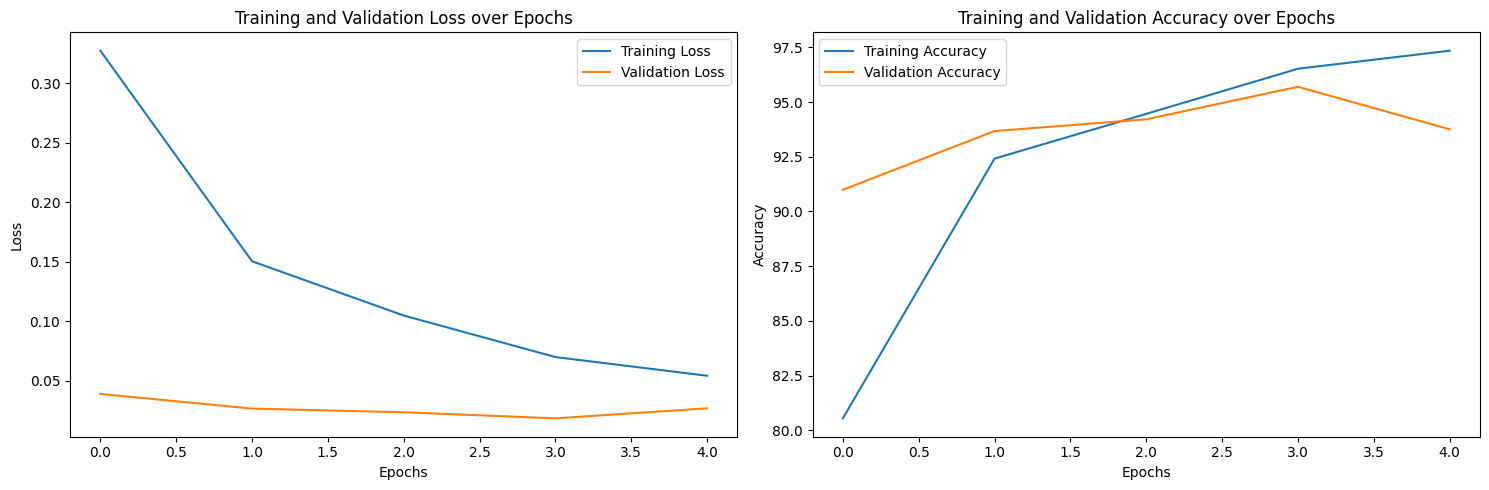

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

# **Работа модели на конкретной картинке из интернета**

Попробуем созданную нейросеть на конкретной картинке из интернета.

В результате, после нескольких попыток загрузить картинки из интернета и попробовать отнести их к одному из трех классов получается что у модели лучше всего получается определять на изображенях собак. Но я больше люблю котов)

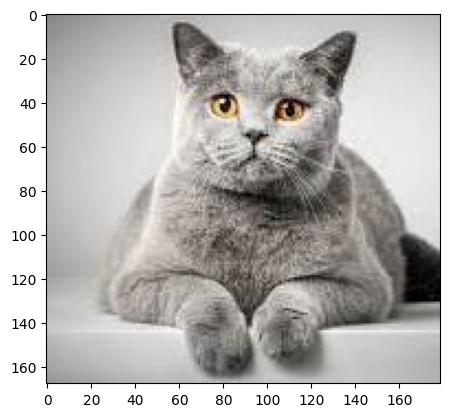


Prediction: 



array(['wild'], dtype=object)

In [21]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

image = Image.open("/content/cat_1.jpg")
plt.imshow(image)
plt.show()


print()
print("Prediction: \n")
predict_image("/content/cat_1.jpg")

# **Сохранение модели**

Сохраним веса и слои модели чтобы использовать в дальнейшем

In [25]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
linear.weight 	 torch.Size([128, 32768])
linear.bias 	 torch.Size([128])
output.weight 	 torch.Size([3, 128])
output.bias 	 torch.Size([3])


In [26]:
torch.save(model.state_dict(),"model.pt")

In [27]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>